In [26]:
import os
import json
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from reinforced_lib import RLib
from reinforced_lib.exts import BaseExt, observation, parameter
from reinforced_lib.agents.mab import UCB, EGreedy, Softmax
from tqdm import tqdm
from chex import PRNGKey, Array
from typing import Dict, List

from gupb.controller import r2d2
from gupb.__main__ import load_initial_config, configure_logging
from gupb import runner

MAB_CONFIG_PATH = 'gupb/mab_config.py'
RESULTS_PATH = 'results'
ARENAS_PATH = 'resources/arenas'
SAVE_PATH = 'mab-results.json'

key = jax.random.PRNGKey(324)

In [23]:
def plot_resuls(results_dict: Dict, scatter: bool = True, smooth: int = 1):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    for agent_name, result in results_dict.items():
        n_steps = len(result['actions'])
        rewards_smooth = jnp.convolve(jnp.array(result['rewards']), jnp.ones(smooth)/smooth, mode='valid')
        if scatter:
            ax[0].scatter(range(len(result['actions'])), result['actions'], label=agent_name, s=1, alpha=0.75)
            ax[1].scatter(range(len(rewards_smooth)), rewards_smooth, label=agent_name, s=1, alpha=0.75)
        else:
            ax[0].plot(range(len(result['actions'])), result['actions'], label=agent_name)
            ax[1].plot(range(len(rewards_smooth)), rewards_smooth, label=agent_name)
    ax[0].set_title('Actions')
    ax[1].set_title('Rewards')
    ax[0].legend()
    ax[1].legend()
    ax[1].set_yscale('log')
    plt.show()

## GUPB environment

In [3]:
configure_logging(RESULTS_PATH)
base_config = load_initial_config(MAB_CONFIG_PATH)
enymies_controllers = base_config["controllers"]

In [4]:
def sample_arenas(key: PRNGKey, n_arenas: int = 1) -> str:

    arenas = os.listdir(ARENAS_PATH)
    arenas = list(filter(lambda a: a.startswith('generated_'), arenas))
    sample_idices = jax.random.choice(key, jnp.arange(len(arenas)), (min(n_arenas, len(arenas)),), replace=False)
    
    return [arenas[i].split('.')[0] for i in sample_idices]

def sample_arena(key: PRNGKey, arenas: List[str]) -> str:
    sample_idices = jax.random.choice(key, jnp.arange(len(arenas)), (1,))
    return [arenas[sample_idices[0]]]

In [5]:
def r2d2_score(decay: int, base_config: Dict, arena: List[str]):

    # Redefine config with new R2D2 decay
    config = base_config.copy()
    config["controllers"] = [r2d2.RecklessRoamingDancingDruid("R2D2", decay=decay)] + enymies_controllers
    config["arenas"] = arena

    # Run the game
    game_runner = runner.Runner(config)
    game_runner.run()

    # Return the score as reward
    r2d2_reward = game_runner.scores["RecklessRoamingDancingDruid_R2D2"]
    return r2d2_reward

In [6]:
r2d2_score(5, base_config, ["generated_0"])

41

## Multi Armed Bandidts

### Problem definition

In [7]:
decay_arms = jnp.round(jnp.logspace(0, 2, base=10, num=10))
print(f"Decay (arms): {decay_arms})")

Decay (arms): [  1.   2.   3.   5.   8.  13.  22.  36.  60. 100.])


In [8]:
class GUPBExt(BaseExt):
    """
    Reinforced-lib extension for tunnig R2D2s parameters in GUPB.
    This extension can be used with Multi-Armed Bandit (MAB) algorithms.
    """

    def __init__(self, n_arms: int) -> None:
        super().__init__()
        self.n = n_arms

    observation_space = gym.spaces.Dict({})

    @parameter(parameter_type=gym.spaces.Box(1, np.inf, (1,), np.int32))
    def n_arms(self) -> int:
        return self.n

    @observation(observation_type=gym.spaces.Box(-np.inf, np.inf, (1,)))
    def reward(self, reward, *args, **kwargs) -> float:
        return reward

In [9]:
agents = {
    'EGreedy': RLib(
        agent_type=EGreedy,
        agent_params={'e': 0.1, 'optimistic_start': 50.},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(decay_arms)}
    ),
    'Softmax': RLib(
        agent_type=Softmax,
        agent_params={'lr': 2., 'tau': 8.7, 'multiplier': 1.0},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(decay_arms)}
    ),
    'UCB': RLib(
        agent_type=UCB,
        agent_params={'c': 10},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(decay_arms)}
    )
}

### Training loop

In [10]:
def run_agent(key: PRNGKey, agent: RLib, n_steps: int, arenas: List[str], agent_name: str):

    key, key_arena = jax.random.split(key)
    
    # Perform first action and get first reward
    act_acc = [decay_arms[0].item()]
    reward_acc = [r2d2_score(act_acc[0], base_config, sample_arena(key_arena, arenas))]

    # Sample actions and rewards for n_steps
    for _ in tqdm(range(n_steps), desc=f"{agent_name} agent"):
        key, key_arena = jax.random.split(key)

        # Sample action from mab agent
        act = agent.sample(reward_acc[-1])

        # Get reward for action
        reward = r2d2_score(act, base_config, sample_arena(key_arena, arenas))

        # Accumulate action-reward pair
        act_acc.append(int(act))
        reward_acc.append(reward)
    
    return act_acc, reward_acc

In [11]:
# Prepare arenas and results accumulator
key, key_arenas = jax.random.split(key)
arenas = sample_arenas(key_arenas, n_arenas=5)
results_dict = {}

# Train each agent for n_steps
n_steps = 5
for agent_name, agent in agents.items():
    act_acc, reward_acc = run_agent(key, agent, n_steps, arenas, agent_name)
    results_dict[agent_name] = {
        "actions": act_acc,
        "rewards": reward_acc
    }

# Persist results
with open(SAVE_PATH, 'w') as fp:
    json.dump(results_dict, fp)

UCB agent: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


### Evaluation

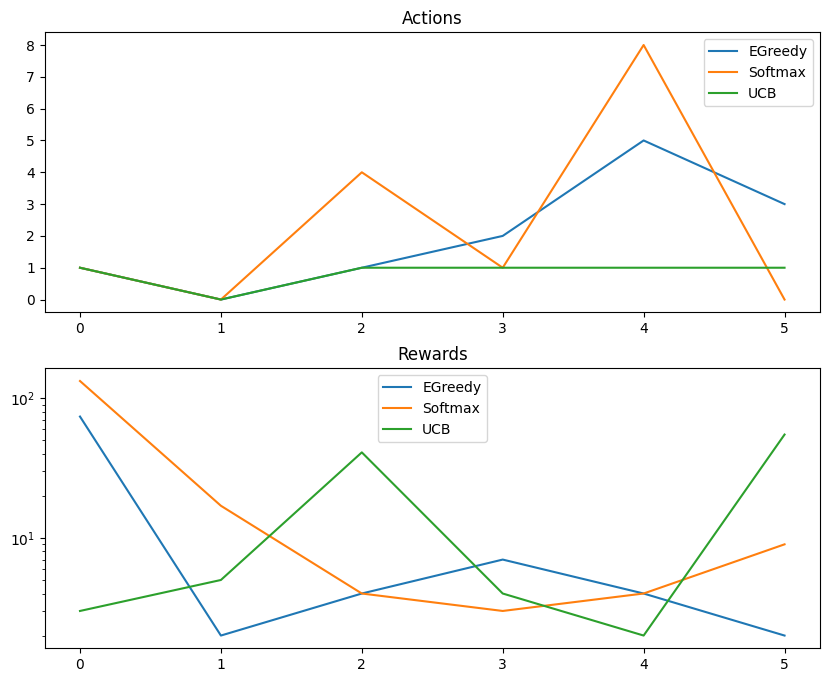

In [33]:
results_loaded = json.load(open(SAVE_PATH, 'r'))
plot_resuls(results_loaded, scatter=False, smooth=1)